In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from pandas.api.types import CategoricalDtype


from scipy.stats import pearsonr

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Loading Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1. Variable identification
SalePrice is the target variable and the rest are the predcitor variable.

In [4]:
global measure_columns_spread_df, list_of_columns_with_null_values
list_of_columns_with_null_values = []
measure_columns_spread_df = pd.DataFrame(columns = ['col_name', 'skewness', 'kurtosis', 'transformation_reqd', 'null_values'])
def collect_calculate_col_spread(df, col):
    global measure_columns_spread_df
    temp = pd.DataFrame(pd.Series([col, df[col].skew(), df[col].kurt(), np.nan, np.nan])).T
    temp.columns = ['col_name', 'skewness', 'kurtosis', 'transformation_reqd', 'null_values']
    condition = (df[col].skew() < -1) | (df[col].skew() > 1) | (df[col].kurt() < -1) | ((df[col].kurt() > 1))
    temp.loc[0,'transformation_reqd']=np.where(condition, 'Yes', 'No')
    temp.loc[0, 'null_values'] = np.where(df[col].isnull().sum(), 'Present', 'Absent')
    if (df[col].isnull().sum()):
        list_of_columns_with_null_values.append(col)
    print("Count of null values in train dataset: ", df[col].isnull().sum())
    measure_columns_spread_df = pd.concat([measure_columns_spread_df, temp], ignore_index = True)
    
    
def univariate_numerical_analysis(df, col):
    collect_calculate_col_spread(df, col)
    fig, axs = plt.subplots(2,1, figsize = (10,9));
    sns.distplot(train[col], ax = axs[0]);
    axs[0].set_title("Histogram of " + col);
    axs[1].set_title("Boxplot of " + col);
    sns.boxplot(train[col], ax = axs[1]);
    title=("Skewness of {}: ".format(col) + "{0:.2f}".format(train[col].skew()) + " and " + "Kurtosis of {}: ".format(col) 
           +"{0:.2f}".format(train[col].kurt()))
    fig.suptitle(title, y = 1.01);
    plt.tight_layout(); 
    plt.show();

Count of null values in train dataset:  0


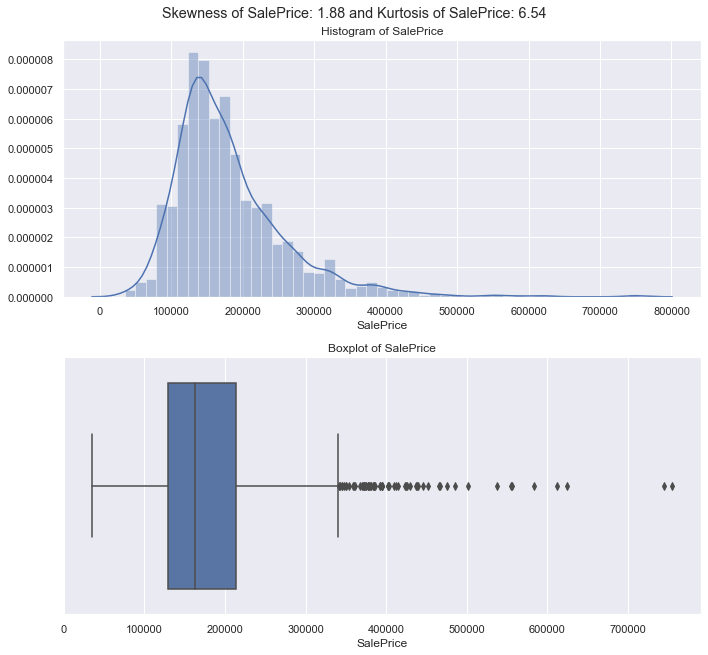

In [5]:
univariate_numerical_analysis(train, 'SalePrice')

## Combining train and test set into one dataset for easir data wrangling

In [6]:
train['SalePrice_Log'] = np.log(train['SalePrice'])
train.drop(columns = 'SalePrice', inplace = True)

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_Log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


#### rbinding train and test data

In [8]:
data = pd.concat([train.drop(columns='SalePrice_Log'), test], axis = 0)
data.shape

(2919, 80)

In [9]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
data.drop(columns = 'Id', inplace = True)

In [11]:
data.isnull().sum()[data.isnull().sum()!=0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

Dropping columns whihc have 50% of its values as NA

Filling NA values of numerical columns

In [12]:
for col in ['BsmtHalfBath','BsmtFullBath']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())

In [13]:
for col in ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']:
    data[col] = data[col].fillna(data[col].median())

In [14]:
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea']:
    data[col] = data[col].fillna(data[col].median())

Filling NA values of object/categorical columns

In [15]:
for col in ['MasVnrType', 'Electrical']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())

In [16]:
for col in ['Alley', 'GarageType', 'GarageFinish', 'BsmtQual', 'BsmtCond', 'BsmtExposure',  'BsmtFinType1', 'PoolQC',
            'BsmtFinType2', 'FireplaceQu', 'GarageQual',  'GarageCond','Fence', 'MiscFeature']:
    data[col] = data[col].fillna('None')

In [17]:
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].value_counts().index[0])
data['Utilities'] = data['Utilities'].fillna(data['Utilities'].value_counts().index[0])
data['GarageCond'] = data['GarageCond'].fillna('None')
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].value_counts().index[0])
data['Functional'] = data['Functional'].fillna(data['Functional'].value_counts().index[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].value_counts().index[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].value_counts().index[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].value_counts().index[0])

In [18]:
data.isnull().sum()[data.isnull().sum()!=0]

Series([], dtype: int64)

So NA values of all columns are filled.

***

In [19]:
# to check for presence of zero in each columns as log(0) is undefined and will cause error
def count_check_zeros(t):
    return(sum(t==0))
        
data[['GrLivArea', '1stFlrSF', 'LotArea', 'LotFrontage']].apply(count_check_zeros, axis = 0)

GrLivArea      0
1stFlrSF       0
LotArea        0
LotFrontage    0
dtype: int64

In [20]:
for col in ['GrLivArea', '1stFlrSF', 'LotArea', 'LotFrontage']:
    data[col+'_Log'] = np.log(train[col])
    data.drop(columns = col, inplace = True)

Check presence of null values again

In [21]:
data.isnull().sum()[data.isnull().sum()!=0]

LotFrontage_Log    518
dtype: int64

In [22]:
data['LotFrontage_Log'] = data['LotFrontage_Log'].fillna(data['LotFrontage_Log'].median())


### Dealing with all object/category type columns

Converting object columns to ordinal category type

In [23]:
cat_type = CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['IR3', 'IR2', 'IR1', 'Reg'], ordered=True)
data['LotShape'] = data['LotShape'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['PoolQC'] = data['PoolQC'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
data['BsmtExposure'] = data['BsmtExposure'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True)
for col in ['BsmtFinType2', 'BsmtFinType1']:
    data[col] = data[col].astype(cat_type)

In [24]:
cat_type = CategoricalDtype(['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], ordered=True)
data['Fence'] = data['Fence'].astype(cat_type)

In [25]:
cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['KitchenQual'] = data['KitchenQual'].astype(cat_type)
data['HeatingQC'] = data['HeatingQC'].astype(cat_type)

In [26]:
cat_type = CategoricalDtype(['Low', 'HLS', 'Bnk', 'Lvl'], ordered=True)
data['LandContour'] = data['LandContour'].astype(cat_type)

In [27]:
cat_type = CategoricalDtype(['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ordered=True)
data['Utilities'] = data['Utilities'].astype(cat_type)

In [28]:
cat_type = CategoricalDtype(['Sev', 'Mod', 'Gtl'], ordered=True)
data['LandSlope'] = data['LandSlope'].astype(cat_type)

In [29]:
cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['ExterQual', 'ExterCond']:
    data[col] = data[col].astype(cat_type)

In [30]:
cat_type = CategoricalDtype(['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],ordered=True)
data['Functional'] = data['Functional'].astype(cat_type)

In [31]:
cat_type = CategoricalDtype(['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],ordered=True)
data['GarageType'] = data['GarageType'].astype(cat_type)

In [32]:
cat_type = CategoricalDtype(['None', 'Unf', 'RFn', 'Fin'],ordered=True)
data['GarageFinish'] = data['GarageFinish'].astype(cat_type)

In [33]:
cat_type = CategoricalDtype(['N', 'P', 'Y'],ordered=True)
data['PavedDrive'] = data['PavedDrive'].astype(cat_type)

In [34]:
data.shape

(2919, 79)

In [35]:
data.select_dtypes(include=['object']).dtypes.index

Index(['MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'CentralAir', 'Electrical', 'GarageCond', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

This dictionary will be helpful while creating one-hot encoder.

Removing any duplicate rows

In [37]:
data = data.drop_duplicates()

In [38]:
data.shape

(2919, 79)

Create datas for train and test set make sure to use the copy() function

In [39]:
X_train = data.iloc[:len(train),:].copy()
X_test = data.iloc[len(train):,:].copy()

In [40]:
X_train = pd.concat([X_train,train['SalePrice_Log']], axis = 1)

In [41]:
X_train.shape

(1460, 80)

In [42]:
X_test.shape

(1459, 79)

In [43]:
X_train.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GrLivArea_Log,1stFlrSF_Log,LotArea_Log,LotFrontage_Log,SalePrice_Log
0,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,854,0,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,7.444249,6.752270,9.041922,4.174387,12.247694
1,20,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,0,0,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,7.140453,7.140453,9.169518,4.382027,12.109011
2,60,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,866,0,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,7.487734,6.824374,9.328123,4.219508,12.317167
3,70,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,756,0,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,7.448334,6.867974,9.164296,4.094345,11.849398
4,60,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1053,0,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,7.695303,7.043160,9.565214,4.430817,12.429216


Converting ordinal category type columns into ordinal encoded types

In [44]:
len(X_train.select_dtypes(include='category').columns)

21

In [45]:
for col in X_train.select_dtypes(include='category').columns:
    X_train[col] = X_train[col].cat.codes

In [46]:
X_train.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GrLivArea_Log,1stFlrSF_Log,LotArea_Log,LotFrontage_Log,SalePrice_Log
0,60,RL,Pave,None,3,3,3,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,6,706.0,1,0.0,150.0,856.0,GasA,4,Y,SBrkr,854,0,1.0,0.0,2,1,3,1,3,8,7,0,0,5,2003.0,2,2.0,548.0,3,TA,2,0,61,0,0,0,0,0,0,None,0,2,2008,WD,Normal,7.444249,6.752270,9.041922,4.174387,12.247694
1,20,RL,Pave,None,3,3,3,FR2,2,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,4,3,4,5,978.0,1,0.0,284.0,1262.0,GasA,4,Y,SBrkr,0,0,0.0,1.0,2,0,3,1,2,6,7,1,3,5,1976.0,2,2.0,460.0,3,TA,2,298,0,0,0,0,0,0,0,None,0,5,2007,WD,Normal,7.140453,7.140453,9.169518,4.382027,12.109011
2,60,RL,Pave,None,2,3,3,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,6,486.0,1,0.0,434.0,920.0,GasA,4,Y,SBrkr,866,0,1.0,0.0,2,1,3,1,3,6,7,1,3,5,2001.0,2,2.0,608.0,3,TA,2,0,42,0,0,0,0,0,0,None,0,9,2008,WD,Normal,7.487734,6.824374,9.328123,4.219508,12.317167
3,70,RL,Pave,None,2,3,3,Corner,2,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,4,1,5,216.0,1,0.0,540.0,756.0,GasA,3,Y,SBrkr,756,0,1.0,0.0,1,0,3,1,3,7,7,1,4,1,1998.0,1,3.0,642.0,3,TA,2,0,35,272,0,0,0,0,0,None,0,2,2006,WD,Abnorml,7.448334,6.867974,9.164296,4.094345,11.849398
4,60,RL,Pave,None,2,3,3,FR2,2,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,6,655.0,1,0.0,490.0,1145.0,GasA,4,Y,SBrkr,1053,0,1.0,0.0,2,1,4,1,3,9,7,1,3,5,2000.0,2,3.0,836.0,3,TA,2,192,84,0,0,0,0,0,0,None,0,12,2008,WD,Normal,7.695303,7.043160,9.565214,4.430817,12.429216


In [47]:
numeric_dtypes = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(X_train.select_dtypes(include = numeric_dtypes).columns)
numerical_columns[:6]

['MSSubClass',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'OverallQual']

In [48]:
len(numerical_columns)

58

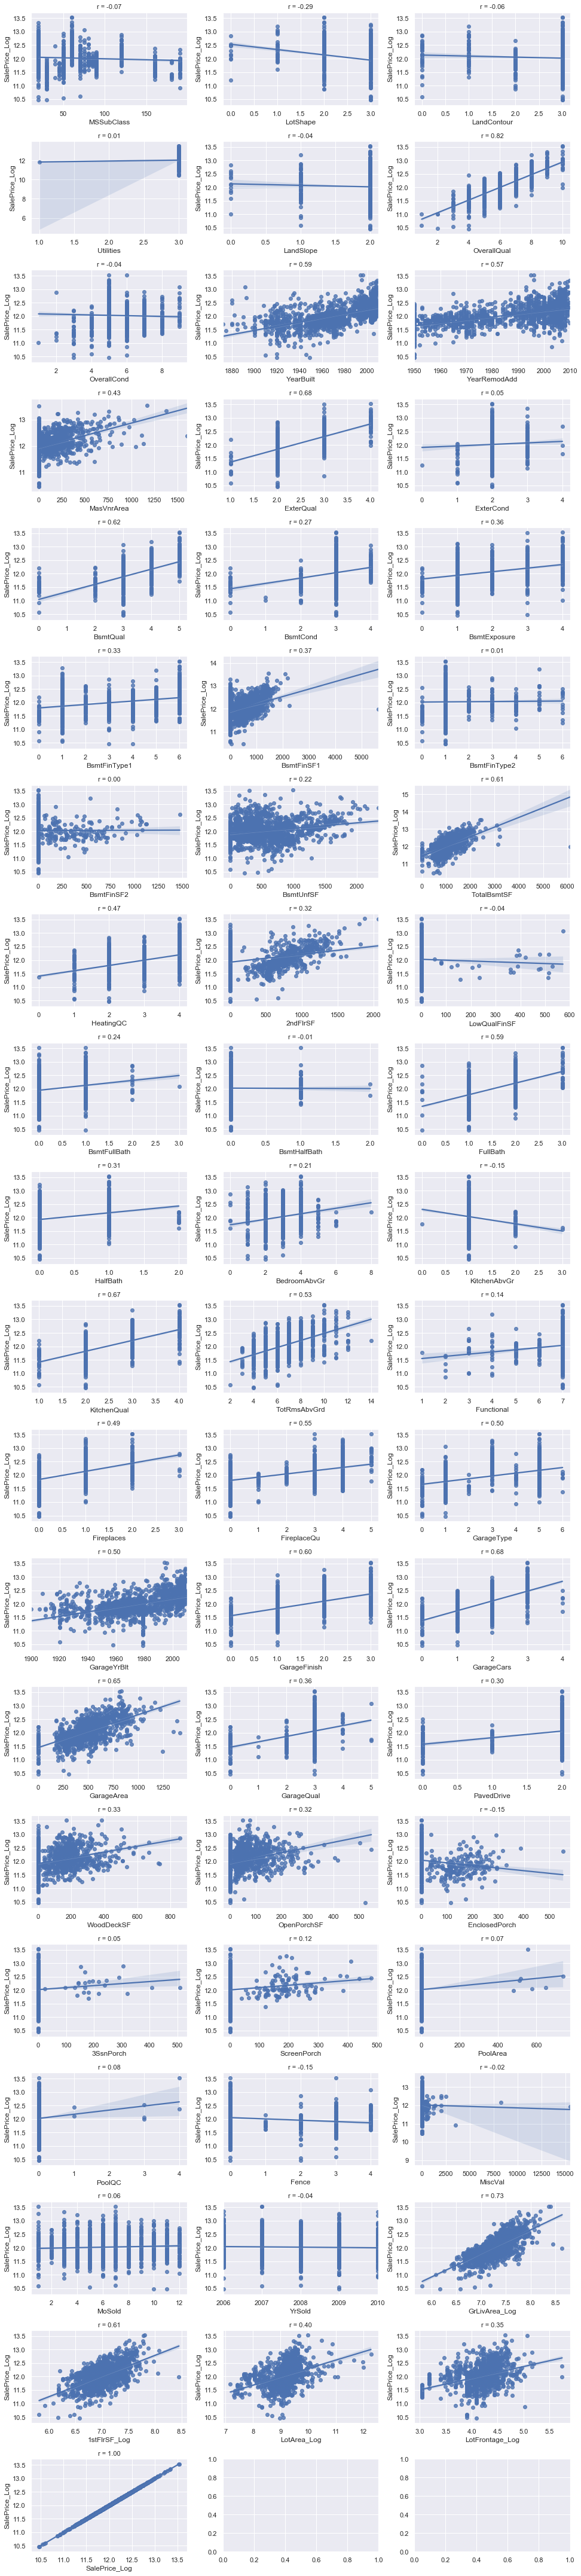

In [49]:
correlation_results_list = []
nrows = 20
ncols = 3
fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist] 
for col in numerical_columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    sns.regplot(X_train[col], X_train['SalePrice_Log'], ax = ax)
    stp = pearsonr(X_train[col], X_train['SalePrice_Log'])
    str_title = "r = " + "{0:.2f}".format(stp[0])
    ax.set_title(str_title,fontsize=11)
    correlation_results_list.append((col, abs(stp[0])))
    
plt.tight_layout(); 
plt.show();

In [50]:
correlation_df = pd.DataFrame(correlation_results_list, columns = ['column_name', 'correlation'])
correlation_df

,column_name,correlation
0,MSSubClass,0.073959
1,LotShape,0.286002
2,LandContour,0.057865
3,Utilities,0.012632
4,LandSlope,0.038526
5,OverallQual,0.817184
6,OverallCond,0.036868
7,YearBuilt,0.586570
8,YearRemodAdd,0.565608
9,MasVnrArea,0.426775


In [51]:
correlation_df[correlation_df['correlation']>=0.4]

,column_name,correlation
5,OverallQual,0.817184
7,YearBuilt,0.586570
8,YearRemodAdd,0.565608
9,MasVnrArea,0.426775
10,ExterQual,0.678840
12,BsmtQual,0.615804
20,TotalBsmtSF,0.612134
21,HeatingQC,0.473762
26,FullBath,0.594771
30,KitchenQual,0.667893


Columns to be deleted from train/test/X_train dataset which have very low correlation.

In [52]:
for col in correlation_df['column_name'][correlation_df['correlation']<0.4]:
    X_test.drop(columns = col, inplace = True)
    X_train.drop(columns = col, inplace = True)
    data.drop(columns = col, inplace = True)

In [53]:
X_train.shape

(1460, 43)

In [54]:
X_test.shape

(1459, 42)

In [55]:
data.shape

(2919, 42)

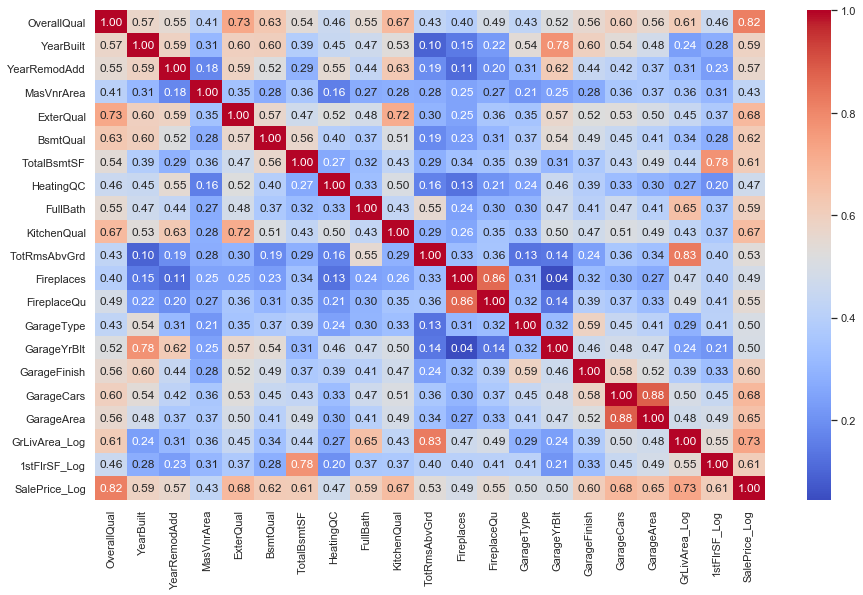

In [56]:
plt.figure(figsize=(15,9))
sns.heatmap(X_train.corr(), annot=True, fmt = '.2f', cmap='coolwarm');

Dropping columns having high value of correlation to avoid multicolinearity
Columns with high correlation i.e., more than 0.8:

- TotRmsAbvGrd and GrLivArea_Log
- GarageArea and GarageCars
- Fireplaces and FireplaceQu

In [57]:
for col in ['TotRmsAbvGrd', 'GarageArea', 'Fireplaces']:
    X_train.drop(columns = col, inplace = True)
    X_test.drop(columns = col, inplace = True)
    data.drop(columns = col, inplace = True)

Trying to find association between the nominal category columns

In [58]:
global categ_columns_with_high_association, categ_columns_with_low_association
categ_columns_with_high_association = []
categ_columns_with_low_association = []
def perform_anova_and_its_results(categ_col, num_col='SalePrice_Log', df = X_train):
    
    from scipy.stats import f
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    
    df_sst = len(df[num_col])-1
    df_ssb = df[categ_col].nunique() - 1
    df_ssw = df_sst - df_ssb
    F_critical = f.ppf(0.95, df_ssb, df_ssw)
    print("F_Critical: {0:.3f}".format(F_critical))
    results = ols('{} ~{}'.format(num_col, categ_col), data = train).fit()
    aov_table = sm.stats.anova_lm(results, typ = 1)  
    F_stat = aov_table.loc[categ_col, 'F']
    print("F_statistic: {0:.3f}".format(F_stat))
    if (F_stat > F_critical):
        print("F-statistic is more than F-critical")
        print("There is an association between {} and {}".format(categ_col,num_col))
        categ_columns_with_high_association.append(categ_col)
    else:
        print("F-statistic is less than F-critical")
        print("There is no association between {} and {}".format(categ_col,num_col))
        categ_columns_with_low_association.append(categ_col)
    print('-'*30)

In [59]:
for col in X_train.select_dtypes(include = 'object').columns:
    perform_anova_and_its_results(col)

F_Critical: 2.378
F_statistic: 77.608
F-statistic is more than F-critical
There is an association between MSZoning and SalePrice_Log
------------------------------
F_Critical: 3.848
F_statistic: 4.814
F-statistic is more than F-critical
There is an association between Street and SalePrice_Log
------------------------------
F_Critical: 3.002
F_statistic: 27.007
F-statistic is more than F-critical
There is an association between Alley and SalePrice_Log
------------------------------
F_Critical: 2.378
F_statistic: 8.692
F-statistic is more than F-critical
There is an association between LotConfig and SalePrice_Log
------------------------------
F_Critical: 1.525
F_statistic: 79.520
F-statistic is more than F-critical
There is an association between Neighborhood and SalePrice_Log
------------------------------
F_Critical: 1.945
F_statistic: 8.038
F-statistic is more than F-critical
There is an association between Condition1 and SalePrice_Log
------------------------------
F_Critical: 2.016

In [60]:
categ_columns_with_low_association

[]

In [61]:
categ_columns_with_high_association

['MSZoning',
 'Street',
 'Alley',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageCond',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

So all the nominal columns have high association with SalePrice_Log.

In [62]:
X_train.shape

(1460, 40)

In [63]:
X_test.shape

(1459, 39)

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder,OrdinalEncoder

In [66]:
temp = X_train.select_dtypes(include=numeric_dtypes).columns.to_list()
temp.remove('SalePrice_Log')

In [77]:
train_updated = data.iloc[:len(train),:].copy()
test_updated = data.iloc[len(train):,:].copy()

In [80]:
train_updated = pd.concat([train_updated,X_train['SalePrice_Log']], axis = 1)
train_updated.shape

(1460, 40)

In [79]:
test_updated.shape

(1459, 39)

In [81]:
X = train_updated.loc[:,train_updated.columns[train_updated.columns!='SalePrice_Log']]
y = train_updated['SalePrice_Log'].copy()

In [82]:
X.head()

,MSZoning,Street,Alley,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FullBath,KitchenQual,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageCond,MiscFeature,SaleType,SaleCondition,GrLivArea_Log,1stFlrSF_Log
0,RL,Pave,None,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,856.0,GasA,Ex,Y,SBrkr,2,Gd,None,Attchd,2003.0,RFn,2.0,TA,None,WD,Normal,7.444249,6.752270
1,RL,Pave,None,FR2,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,1262.0,GasA,Ex,Y,SBrkr,2,TA,TA,Attchd,1976.0,RFn,2.0,TA,None,WD,Normal,7.140453,7.140453
2,RL,Pave,None,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,920.0,GasA,Ex,Y,SBrkr,2,Gd,TA,Attchd,2001.0,RFn,2.0,TA,None,WD,Normal,7.487734,6.824374
3,RL,Pave,None,Corner,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,756.0,GasA,Gd,Y,SBrkr,1,Gd,Gd,Detchd,1998.0,Unf,3.0,TA,None,WD,Abnorml,7.448334,6.867974
4,RL,Pave,None,FR2,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,1145.0,GasA,Ex,Y,SBrkr,2,Gd,TA,Attchd,2000.0,RFn,3.0,TA,None,WD,Normal,7.695303,7.043160


In [36]:
ohe_dict_cols = {}
for col in data.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(data[col].unique()).to_list()

In [65]:
# For one-hot encoder
t_k = []
t_v = []
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

In [93]:
len(X.select_dtypes(include='category').columns)

7

In [112]:
ord_encod_dict = {}
for col in X.select_dtypes(include='category').columns:
    ord_encod_dict[col] = pd.Series(data[col].unique().sort_values()).to_list()

In [113]:
# For ordinal encoder
ordinal_cols = []
ordinal_vals = []
for k,v in ord_encod_dict.items():
    ordinal_cols.append(k)
    ordinal_vals.append(v)

In [94]:
len(X.select_dtypes(include='object').columns)

22

In [103]:
len(X.select_dtypes(include=numeric_dtypes).columns)

10

In [116]:
colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
 'FullBath', 'GarageYrBlt', 'GarageCars', 'GrLivArea_Log', '1stFlrSF_Log']),
    ('ordinal_col', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

In [117]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model  import LinearRegression

In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Linear regression

In [119]:
from sklearn.linear_model  import LinearRegression
lin_reg = LinearRegression()

pipeline = Pipeline(steps = [("colt", colT), ("regl",lin_reg)])
param_grid = {"regl__fit_intercept":[True,False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = 10, scoring = 'neg_root_mean_squared_error')

grid.fit(X, y)

# best algorithm
reg = grid.best_estimator_

reg.fit(X,y)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.3s finished


Pipeline(memory=None,
         steps=[('colt',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('dummy_col',
                                                  OneHotEncoder(categories=[['RL',
                                                                             'RM',
                                                                             'C '
                                                                             '(all)',
                                                                             'FV',
                                                                             'RH'],
                                                                            ['Pave',
                                                                             'Grvl'],
                           

In [120]:
prediction = reg.predict(test_updated)

In [121]:
prediction

array([11.67477085, 12.0312167 , 12.1289306 , ..., 11.85547133,
       11.62326155, 12.19003897])

In [ ]:
from sklearn.svm import SVR

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regressor = LinearRegression()

In [ ]:
pipe = make_pipeline(colT, regressor)

In [ ]:
cross_val_score(pipe, X, y, cv = 12, scoring = 'neg_root_mean_squared_error').mean()

- To see the valid scoring values to be used in cross validation: [check this link](https://scikit-learn.org/stable/modules/model_evaluation.html)
- And to see the valid metrics that can be used here use the following code:
```
import sklearn
sorted(sklearn.metrics.SCORERS.keys())
```